In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import pickle

# Default Prediction

In [2]:
final_cols_unbanked = [
    "FLAG_OWN_CAR",
    "NAME_EDUCATION_TYPE",
    "DAYS_EMPLOYED",
    "CODE_GENDER",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "NAME_INCOME_TYPE",
    "NAME_FAMILY_STATUS",
    "OCCUPATION_TYPE",
    "AMT_INCOME_TOTAL",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
]

final_cols_unbanked_refined = [
    "FLAG_OWN_CAR",
    "NAME_EDUCATION_TYPE",
    "DAYS_EMPLOYED",
    "REG_CITY_NOT_LIVE_CITY",
    "AMT_GOODS_PRICE",
    "REG_CITY_NOT_WORK_CITY",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "NAME_INCOME_TYPE",
    "NAME_FAMILY_STATUS",
    "OCCUPATION_TYPE",
    "AMT_INCOME_TOTAL",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
]


In [3]:
df = pd.read_csv("./data/application_train.csv")
## clean up some rows
df["DAYS_EMPLOYED"][df["DAYS_EMPLOYED"] == 365243] = np.nan
df["OBS_30_CNT_SOCIAL_CIRCLE"][df["OBS_30_CNT_SOCIAL_CIRCLE"] > 30] == np.nan
df["OBS_60_CNT_SOCIAL_CIRCLE"][df["OBS_60_CNT_SOCIAL_CIRCLE"] > 30] == np.nan
df = df[df["CODE_GENDER"] != "XNA"]
df["DAYS_BIRTH"] = df["DAYS_BIRTH"] * -1 / 365
categorical_columns = df.dtypes[df.dtypes == "object"].index.tolist()
df[categorical_columns] = df[categorical_columns].fillna("XNA")
df["REGION_RATING_CLIENT"] = df["REGION_RATING_CLIENT"].astype("object")
df["REGION_RATING_CLIENT_W_CITY"] = df["REGION_RATING_CLIENT_W_CITY"].astype("object")

## remove rows with only 1 distinct value
empty_columns = []
for col in df.columns:
    if len(df[col].unique()) <= 1:
        empty_columns.append(col)
df = df.drop(empty_columns, axis=1)

# shitty self made encoder
encoder_dict = {}
for col in list(df.columns):
    if str(df[col].dtypes) == "object":
        tmp = list(df[col].unique())
        encoder = {name: i for i, name in enumerate(tmp)}
        encoder_dict[col] = encoder
        df[col] = df[col].apply(lambda x: encoder[x])
raw_df = df.copy()
target_df = df.pop("TARGET")


<ipython-input-3-5451a8889216>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DAYS_EMPLOYED"][df["DAYS_EMPLOYED"] == 365243] = np.nan


In [25]:
## Getting average values
average = {}
for col in final_cols_unbanked_refined:
    if raw_df[col].dtype == np.float64:
        _mean = raw_df.groupby("TARGET", as_index=False)[col].mean().iloc[0][1]
        _std = raw_df.groupby("TARGET", as_index=False)[col].std().iloc[0][1]
        average[col] = {"mean": _mean, "std": _std}
    # if raw_df[col].dtype == np.int64:
    #     print(raw_df.groupby(["TARGET", col]).size().reset_index(name='counts').to_dict())
average


{'DAYS_EMPLOYED': {'mean': -2438.111433881319, 'std': 2372.375648763242},
 'AMT_GOODS_PRICE': {'mean': 542738.5067752501, 'std': 373786.3801299267},
 'DAYS_BIRTH': {'mean': 44.214281811217745, 'std': 11.956693909132996},
 'AMT_CREDIT': {'mean': 602651.1583546175, 'std': 406847.90749584715},
 'AMT_INCOME_TOTAL': {'mean': 169077.4721999809, 'std': 110476.90792473988}}

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df[final_cols_unbanked_refined], target_df, test_size=0.2, random_state=69
)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)


In [27]:
## Hyper param tuning
def xgb_eval(
    max_depth,
    min_child_weight,
    gamma,
    subsample,
    colsample_bytree,
    colsample_bylevel,
    colsample_bynode,
    reg_alpha,
    reg_lambda,
):
    params = {
        "objective": "reg:logistic",
        "learning_rate": 0.01,
        # "n_estimators": 10000,
        "max_depth": int(round(max_depth)),
        "min_child_weight": int(round(min_child_weight)),
        "subsample": subsample,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "colsample_bylevel": colsample_bylevel,
        "colsample_bynode": colsample_bynode,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "random_state": 69,
    }
    bst = xgb.train(params, dtrain, num_boost_round=5, verbose_eval=False)
    y_pred = bst.predict(dtest)
    res = roc_auc_score(y_test, y_pred)
    print(res)
    return res


bopt_xgb = BayesianOptimization(
    xgb_eval,
    {
        "max_depth": (5, 15),
        "min_child_weight": (5, 80),
        "gamma": (0.2, 1),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
        "colsample_bylevel": (0.3, 1),
        "colsample_bynode": (0.3, 1),
        "reg_alpha": (0.001, 0.3),
        "reg_lambda": (0.001, 0.3),
    },
    random_state=69,
)
bopt_xgb.maximize(n_iter=6, init_points=4)


|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
0.6418266673735578
|  1        |  0.6418   |  0.5074   |  0.8663   |  0.6751   |  0.8315   |  10.61    |  24.02    |  0.03239  |  0.01848  |  0.8366   |
0.6505886848505251
|  2        |  0.6506   |  0.7885   |  0.8129   |  0.8939   |  0.2611   |  8.177    |  60.58    |  0.09922  |  0.1416   |  0.5905   |
0.6391388208752641
|  3        |  0.6391   |  0.5265   |  0.6184   |  0.7648   |  0.4344   |  7.77     |  55.86    |  0.0708   |  0.2035   |  0.7162   |
0.6404092810771391
|  4        |  0.6404   |  0.5714   |  0.5348   |  0.7566   |  0.9902   |  10.31    |  56.03    |  0.1179   |  0.03585  |  0.8536   |
0.6490571937450651
|  5        |  0.6491   |  0.8547   |  0.843    |  0.9049   |  0.2      |  7.983    |  62.17    |  0.

In [8]:
## best params
params = bopt_xgb.max['params']
## convert params to int
for k in ["max_depth", 'min_child_weight']:
    params[k] = int(params[k])

## basic logistic reg
xg_reg = xgb.XGBRegressor(objective="reg:logistic", **params)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
accuracy = accuracy_score(y_test, [round(i) for i in y_pred])
print(f"Accuracy: {accuracy}")

RMSE: 0.27057985462647055
Accuracy: 0.918506715228773


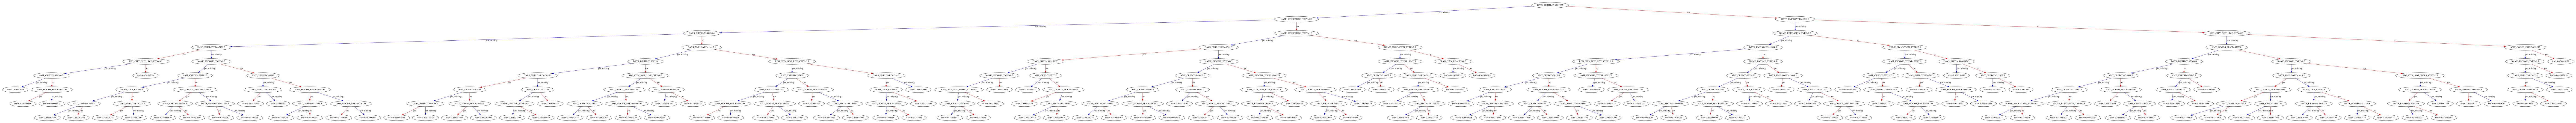

In [9]:
## get score card
xgb.plot_tree(xg_reg)
plt.gcf().set_size_inches(200, 200)
plt.savefig("scorecard.pdf")

In [10]:
## save nodel for api
xg_reg.save_model("backend/model.json")

In [11]:
## test load and predit
xg_reg_1 = xgb.XGBRegressor()
xg_reg_1.load_model("backend/model.json")

smallest = float("inf")
largest = float("-inf")
ideal = [[], []]
for i in range(len(X_test)):
    pred_val = xg_reg_1.predict(X_test.iloc[i : i + 1])
    if pred_val < smallest:
        smallest = pred_val
        ideal[0] = X_test.iloc[i : i + 1]
    if pred_val > largest:
        largest = pred_val
        ideal[1] = X_test.iloc[i : i + 1]


[        FLAG_OWN_CAR  NAME_EDUCATION_TYPE  DAYS_EMPLOYED  \
 107728             1                    2        -7302.0   
 
         REG_CITY_NOT_LIVE_CITY  AMT_GOODS_PRICE  REG_CITY_NOT_WORK_CITY  \
 107728                       0         157500.0                       1   
 
         DAYS_BIRTH  AMT_CREDIT  NAME_INCOME_TYPE  NAME_FAMILY_STATUS  \
 107728   40.939726    157500.0                 1                   1   
 
         OCCUPATION_TYPE  AMT_INCOME_TOTAL  NAME_HOUSING_TYPE  FLAG_OWN_REALTY  \
 107728                4          301500.0                  0                0   
 
         CNT_CHILDREN  
 107728             0  ,
         FLAG_OWN_CAR  NAME_EDUCATION_TYPE  DAYS_EMPLOYED  \
 246433             0                    0         -223.0   
 
         REG_CITY_NOT_LIVE_CITY  AMT_GOODS_PRICE  REG_CITY_NOT_WORK_CITY  \
 246433                       1         450000.0                       1   
 
         DAYS_BIRTH  AMT_CREDIT  NAME_INCOME_TYPE  NAME_FAMILY_STATUS  \
 246433 

# Loan Amount Prediction

In [28]:
amount_prediction_cols = [
    "FLAG_OWN_CAR",
    "NAME_EDUCATION_TYPE",
    "DAYS_EMPLOYED",
    "REG_CITY_NOT_LIVE_CITY",
    "AMT_GOODS_PRICE",
    "REG_CITY_NOT_WORK_CITY",
    "DAYS_BIRTH",
    "NAME_INCOME_TYPE",
    "NAME_FAMILY_STATUS",
    "OCCUPATION_TYPE",
    "AMT_INCOME_TOTAL",
    "NAME_HOUSING_TYPE",
    "FLAG_OWN_REALTY",
    "CNT_CHILDREN",
]

amount_df = df.pop("AMT_CREDIT")
df2 = df[amount_prediction_cols]

In [34]:
X_train_amount, X_test_amount, y_train_amount, y_test_amount = train_test_split(
    df2, amount_df, test_size=0.2, random_state=69
)

dtrain_amount = xgb.DMatrix(X_train_amount, y_train_amount)
dtest = xgb.DMatrix(X_test_amount, y_test_amount)

## Hyper param tuning
def xgb_eval(
    max_depth,
    min_child_weight,
    gamma,
    subsample,
    colsample_bytree,
    colsample_bylevel,
    colsample_bynode,
    reg_alpha,
    reg_lambda,
):
    params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.01,
        "max_depth": int(round(max_depth)),
        "min_child_weight": int(round(min_child_weight)),
        "subsample": subsample,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "colsample_bylevel": colsample_bylevel,
        "colsample_bynode": colsample_bynode,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "random_state": 69,
    }
    bst = xgb.cv(params, dtrain_amount, num_boost_round=5, verbose_eval=False)
    res = bst["test-rmse-mean"].iloc[0]
    return res


bopt_xgb_amount = BayesianOptimization(
    xgb_eval,
    {
        "max_depth": (5, 15),
        "min_child_weight": (5, 80),
        "gamma": (0.2, 1),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
        "colsample_bylevel": (0.3, 1),
        "colsample_bynode": (0.3, 1),
        "reg_alpha": (0.001, 0.3),
        "reg_lambda": (0.001, 0.3),
    },
    random_state=69,
)
bopt_xgb_amount.maximize(n_iter=6, init_points=4)

## best params
best_params_amount = bopt_xgb_amount.max["params"]
## convert params to int
for k in ["max_depth", "min_child_weight"]:
    best_params_amount[k] = int(best_params_amount[k])

## basic logistic reg
xg_reg_amount = xgb.XGBRegressor(objective="reg:squarederror", **best_params_amount)
xg_reg_amount.fit(X_train_amount, y_train_amount)
y_pred = xg_reg_amount.predict(X_test_amount)
rmse = np.sqrt(mean_squared_error(y_test_amount, y_pred))
print(f"RMSE: {rmse}")

## save nodel for api
xg_reg_amount.save_model("backend/model_amount.json")

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  7.138e+0 |  0.5074   |  0.8663   |  0.6751   |  0.8315   |  10.61    |  24.02    |  0.03239  |  0.01848  |  0.8366   |
|  2        |  7.136e+0 |  0.7885   |  0.8129   |  0.8939   |  0.2611   |  8.177    |  60.58    |  0.09922  |  0.1416   |  0.5905   |
|  3        |  7.138e+0 |  0.5265   |  0.6184   |  0.7648   |  0.4344   |  7.77     |  55.86    |  0.0708   |  0.2035   |  0.7162   |
|  4        |  7.143e+0 |  0.5714   |  0.5348   |  0.7566   |  0.9902   |  10.31    |  56.03    |  0.1179   |  0.03585  |  0.8536   |
|  5        |  7.138e+0 |  0.6496   |  0.431    |  0.8276   |  0.4903   |  10.05    |  16.65    |  0.1309   |  0.2105   |  0.9515   |
|  6        |  7.138e+0 |  0.6761   |  0.4906   |  0.7615   | 

In [60]:
## test load and predict
xg_reg_2 = xgb.XGBRegressor()
xg_reg_2.load_model("backend/model_amount.json")

smallest = float("inf")
largest = float("-inf")
ideal_amount = [[], []]
preds = xg_reg_2.predict(X_test_amount)
for i in range(len(X_test_amount)):
    a = preds[i : i + 1]
    b = y_test_amount[i : i + 1]
    rmse = np.sqrt(mean_squared_error(a, b))
    if i < 10:
        print(rmse, smallest, largest)
    if rmse < smallest:
        smallest = rmse
        ideal_amount[0] = X_test_amount.iloc[i : i + 1]
    if rmse > largest:
        largest = rmse
        ideal_amount[1] = X_test_amount.iloc[i : i + 1]


111734.96875 inf -inf
12253.484375 111734.96875 111734.96875
36672.0625 12253.484375 111734.96875
14544.703125 12253.484375 111734.96875
12618.984375 12253.484375 111734.96875
17045.25 12253.484375 111734.96875
28228.140625 12253.484375 111734.96875
111607.875 12253.484375 111734.96875
121924.1875 12253.484375 111734.96875
72687.75 12253.484375 121924.1875


In [64]:
print(smallest, "\n", largest, "\n", [x.to_dict("records")[0] for x in ideal])

1.9375 
 1383084.0 
 [{'FLAG_OWN_CAR': 1, 'NAME_EDUCATION_TYPE': 2, 'DAYS_EMPLOYED': -775.0, 'REG_CITY_NOT_LIVE_CITY': 0, 'AMT_GOODS_PRICE': 238500.0, 'REG_CITY_NOT_WORK_CITY': 0, 'DAYS_BIRTH': 32.25753424657534, 'NAME_INCOME_TYPE': 2, 'NAME_FAMILY_STATUS': 1, 'OCCUPATION_TYPE': 3, 'AMT_INCOME_TOTAL': 135000.0, 'NAME_HOUSING_TYPE': 0, 'FLAG_OWN_REALTY': 0, 'CNT_CHILDREN': 1}, {'FLAG_OWN_CAR': 0, 'NAME_EDUCATION_TYPE': 0, 'DAYS_EMPLOYED': nan, 'REG_CITY_NOT_LIVE_CITY': 0, 'AMT_GOODS_PRICE': 270000.0, 'REG_CITY_NOT_WORK_CITY': 0, 'DAYS_BIRTH': 57.35342465753425, 'NAME_INCOME_TYPE': 3, 'NAME_FAMILY_STATUS': 1, 'OCCUPATION_TYPE': 4, 'AMT_INCOME_TOTAL': 99000.0, 'NAME_HOUSING_TYPE': 0, 'FLAG_OWN_REALTY': 1, 'CNT_CHILDREN': 0}]


In [ ]:
## Getting average values 
